In [1]:
import utils

In [2]:
project_data = "playground-series-s5e12.zip"
utils.extract_from_zip(project_data)

## Read the data

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [16]:
data_dir = Path(project_data.split('.')[0])
train_data = pd.read_csv(data_dir / "train.csv")
test_data = pd.read_csv(data_dir / "test.csv")

In [19]:
train_data.shape

(700000, 26)

In [20]:
train_data.head().T

,0,1,2,3,4
id,0,1,2,3,4
age,31,50,32,54,54
alcohol_consumption_per_week,1,2,3,3,1
physical_activity_minutes_per_week,45,73,158,77,55
diet_score,7.7,5.7,8.5,4.6,5.7
sleep_hours_per_day,6.8,6.5,7.4,7.0,6.2
screen_time_hours_per_day,6.1,5.8,9.1,9.2,5.1
bmi,33.4,23.8,24.1,26.6,28.8
waist_to_hip_ratio,0.93,0.83,0.83,0.83,0.9
systolic_bp,112,120,95,121,108


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

- No null values in the data.
- some columns with `object` dtype need conversion to float
- object dtype columns are categorical attributes with multiple categories, while `family_history_diabetes`, `hypertension_history` and `cardiovascular_history` are binary categorical attributes already encoded as 0s and 1s.
- drop the `id` column for input to the model.


In [41]:
train_data[['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']].nunique()

family_history_diabetes    2
hypertension_history       2
cardiovascular_history     2
dtype: int64

In [42]:
train_data[['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']].head()

,family_history_diabetes,hypertension_history,cardiovascular_history
0,0,0,0
1,0,0,0
2,0,0,0
3,0,1,0
4,0,1,0


In [43]:
train_data.select_dtypes(object)

,gender,ethnicity,education_level,income_level,smoking_status,employment_status
0,Female,Hispanic,Highschool,Lower-Middle,Current,Employed
1,Female,White,Highschool,Upper-Middle,Never,Employed
2,Male,Hispanic,Highschool,Lower-Middle,Never,Retired
3,Female,White,Highschool,Lower-Middle,Current,Employed
4,Male,White,Highschool,Upper-Middle,Never,Retired
...,...,...,...,...,...,...
699995,Female,Hispanic,Postgraduate,Upper-Middle,Former,Employed
699996,Female,Hispanic,Graduate,Upper-Middle,Former,Employed
699997,Female,White,Graduate,Middle,Never,Employed
699998,Female,White,Highschool,Lower-Middle,Never,Retired


Histograms:

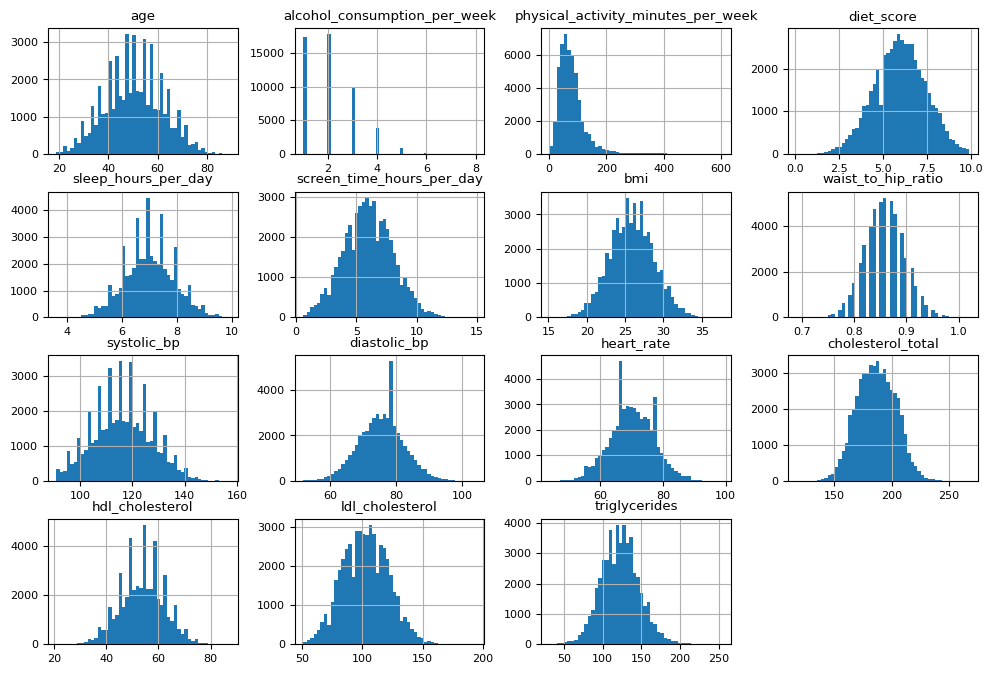

In [56]:
plt.rc('font', size=8)
train_data.iloc[np.random.randint(len(train_data), size=(50_000)), 1:16].hist(bins=50, figsize=(12, 8))
plt.show()

<Axes: xlabel='physical_activity_minutes_per_week', ylabel='diagnosed_diabetes'>

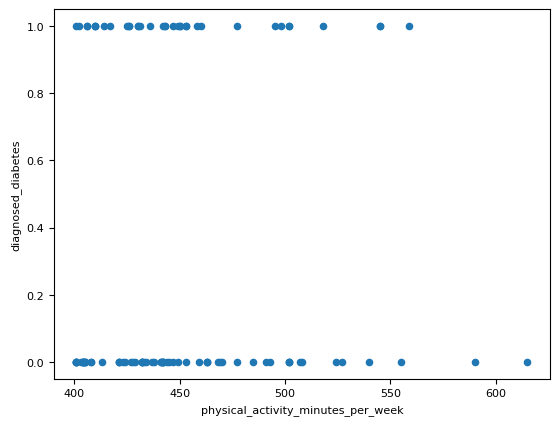

In [60]:
train_data.sample(50000).loc[train_data.physical_activity_minutes_per_week > 400].plot(x="physical_activity_minutes_per_week", y="diagnosed_diabetes", kind="scatter")

<Axes: xlabel='age', ylabel='diagnosed_diabetes'>

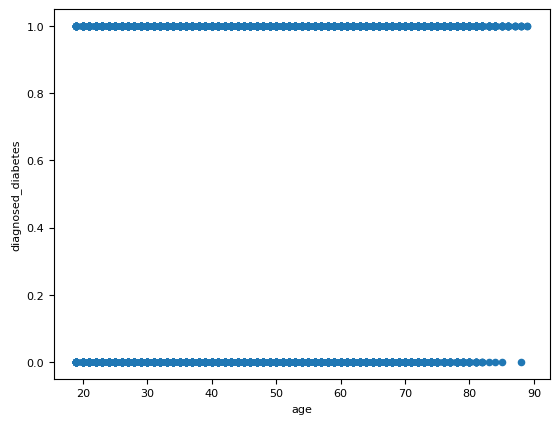

In [64]:
train_data.sample(50000).plot(x="age", y="diagnosed_diabetes", kind="scatter")

In [63]:
train_data.corr(numeric_only=True)['diagnosed_diabetes'].sort_values(ascending=False)

diagnosed_diabetes                    1.000000
family_history_diabetes               0.211064
age                                   0.161162
systolic_bp                           0.107132
bmi                                   0.105580
ldl_cholesterol                       0.102771
triglycerides                         0.090635
cholesterol_total                     0.088112
waist_to_hip_ratio                    0.081050
diastolic_bp                          0.036271
hypertension_history                  0.029979
cardiovascular_history                0.024746
heart_rate                            0.023865
screen_time_hours_per_day             0.018213
sleep_hours_per_day                   0.003509
alcohol_consumption_per_week          0.002991
id                                   -0.000075
diet_score                           -0.050119
hdl_cholesterol                      -0.053231
physical_activity_minutes_per_week   -0.169789
Name: diagnosed_diabetes, dtype: float64

## Create test set

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop("diagnosed_diabetes", axis=1), train_data["diagnosed_diabetes"],
                                                    test_size=.15, random_state=42)

## Data preprocessing

In [71]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

In [79]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))

preprocessing_pipeline = make_column_transformer(
    (num_pipeline, ["age", "physical_activity_minutes_per_week"]),
    (cat_pipeline, ["family_history_diabetes"]),
    remainder='drop'
)

In [80]:
preprocessing_pipeline

,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [82]:
log_reg = make_pipeline(preprocessing_pipeline, LogisticRegression())

In [83]:
log_reg.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [87]:
y_pred_prob_log_reg = log_reg.predict_proba(X_test)

In [88]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [92]:
recall_score(y_test, y_pred_prob_log_reg[:, 1] > 0.5)

0.8793812861932337

In [96]:
roc_auc_score(y_test, y_pred_prob_log_reg[:, 1])

0.6793527659908094

In [101]:
rf = make_pipeline(preprocessing_pipeline, RandomForestClassifier(max_depth=5))
rf.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [102]:
y_pred_prob_rf = rf.predict_proba(X_test)

In [103]:
recall_score(y_test, y_pred_prob_rf[:, 1] > 0.5)

0.8960225540993599

In [104]:
roc_auc_score(y_test, y_pred_prob_rf[:, 1])

0.6867330937129902

## Submission output

In [108]:
def submission_output(estimator, test_data, file_name):
    test_set_predictions = estimator.predict_proba(test_data)[:, 1]
    test_data["diagnosed_diabetes"] = test_set_predictions
    test_data[["id", "diagnosed_diabetes"]].to_csv(file_name, index=False)

In [105]:
# submission_output(log_reg, "01_log_reg_3_variables.csv")

In [106]:
submission_output(rf, "02_rf_3_variables.csv")